# Optimizing Function

## Data

Let's simulate data.

$z = f(x, y) = \sin \left( \sqrt{x^2 + y^2} \right)$

In [1]:
import pandas as pd
import numpy as np

x = np.arange(-5, 5, 0.25)
y = np.arange(-5, 5, 0.25)
x, y = np.meshgrid(x, y)
z = np.sin(np.sqrt(x**2 + y**2))

df = pd.DataFrame([(_x, _y, _z) for _x, _y, _z in zip(np.ravel(x), np.ravel(y), np.ravel(z))], 
                  columns=['x', 'y', 'z'])

x.shape, y.shape, z.shape, df.shape

((40, 40), (40, 40), (40, 40), (1600, 3))

## Surface plot, Matplotlib

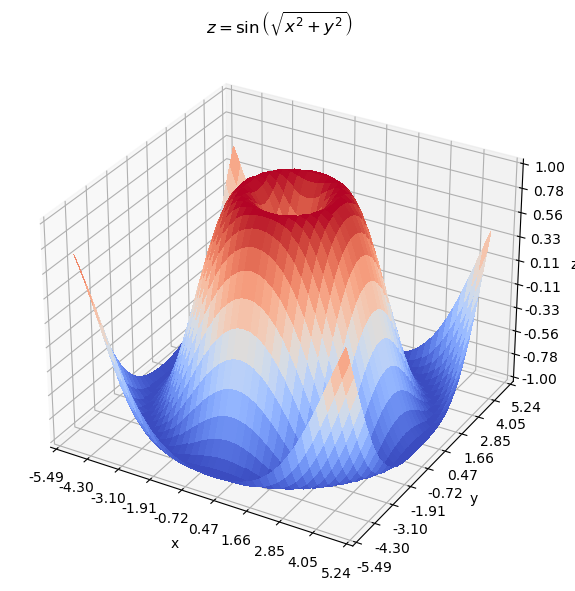

In [64]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(
    subplot_kw={'projection': '3d'}, 
    figsize=(6, 6)
)

surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.xaxis.set_major_locator(LinearLocator(10))
ax.yaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_locator(LinearLocator(10))
ax.xaxis.set_major_formatter('{x:.02f}')
ax.yaxis.set_major_formatter('{x:.02f}')
ax.zaxis.set_major_formatter('{x:.02f}')
ax.set_title(r'$z = \sin \left( \sqrt{x^2 + y^2} \right)$')

fig.tight_layout()

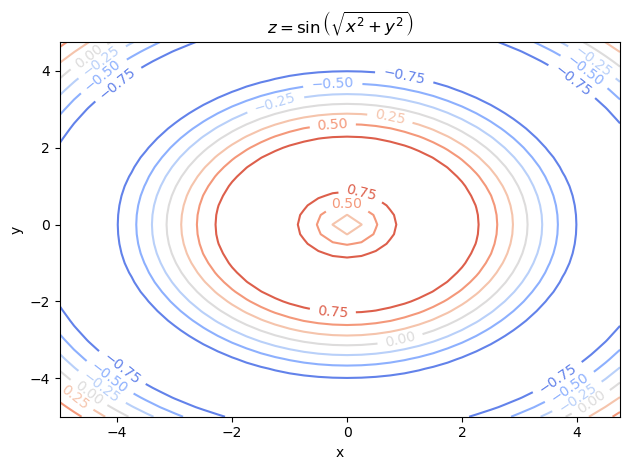

In [67]:
fig, ax = plt.subplots()

qcs = ax.contour(x, y, z, cmap=cm.coolwarm)
ax.clabel(qcs, inline=1, fontsize=10)
ax.set_title(r'$z = \sin \left( \sqrt{x^2 + y^2} \right)$')
ax.set_xlabel('x')
ax.set_ylabel('y')

fig.tight_layout()

## Surface plot, Plotly

In [68]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(
    x=x,
    y=y,
    z=z,
    colorscale='Viridis',
    opacity=0.5,
)])

fig.update_layout(
    title=r'$z = \sin \left( \sqrt{x^2 + y^2} \right)$',
    autosize=False,
    width=600,
    height=600,
    margin={'l': 65, 'r': 50, 'b': 65, 't': 90}
)
fig.update_xaxes(title='x')
fig.update_yaxes(title='y')

fig.show()

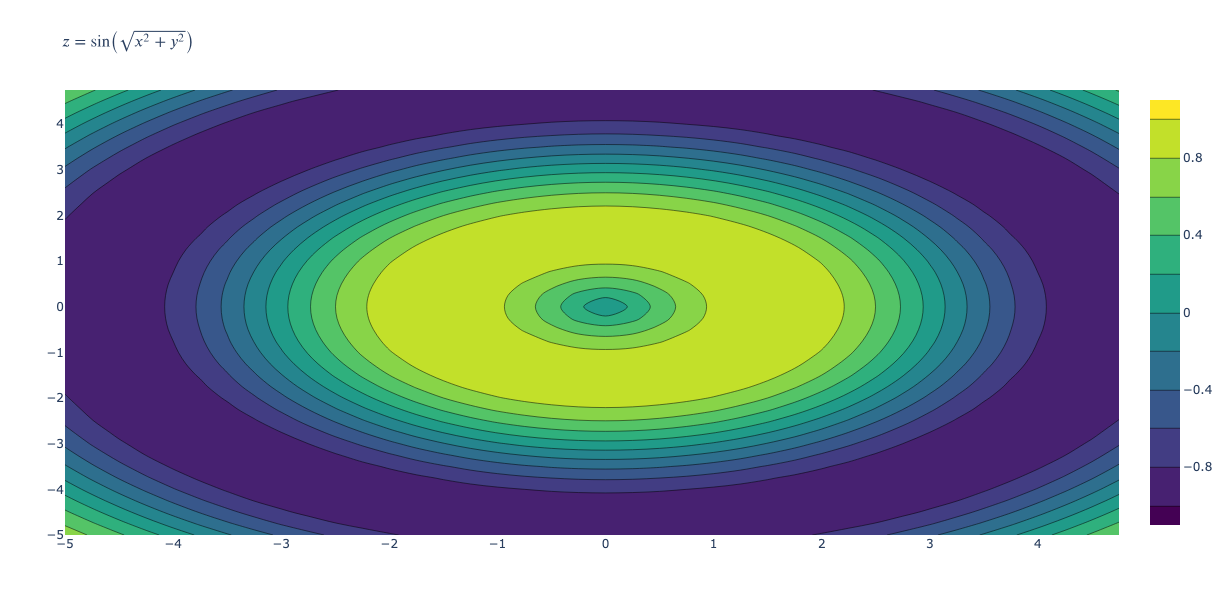

In [75]:
fig = go.Figure(data =
    go.Contour(
        z=z,
        x=df['x'].unique(),
        y=df['y'].unique(),
        colorscale='Viridis'
    ))
fig.update_layout(
    title=r'$z = \sin \left( \sqrt{x^2 + y^2} \right)$',
    autosize=False,
    width=600,
    height=600,
    margin={'l': 65, 'r': 50, 'b': 65, 't': 90}
)

fig.show()

## Optimal points

In [30]:
df[df['z']==df['z'].max()]

,x,y,z
578,-0.5,-1.5,0.999947
582,0.5,-1.5,0.999947
734,-1.5,-0.5,0.999947
746,1.5,-0.5,0.999947
894,-1.5,0.5,0.999947
906,1.5,0.5,0.999947
1058,-0.5,1.5,0.999947
1062,0.5,1.5,0.999947


## Modeling

In [81]:
from sklearn.ensemble import RandomForestRegressor

m = RandomForestRegressor(random_state=37, n_jobs=-1, n_estimators=50)
m.fit(df[['x', 'y']], df['z'])

RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=37)

In [82]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(df['z'], m.predict(df[['x', 'y']]))

0.011997664199503582

In [88]:
_x, _y = np.meshgrid(np.arange(-5, 5, 0.25), np.arange(-5, 5, 0.25))
_z = m.predict(pd.DataFrame([(_x_val, _y_val) for _x_val, _y_val in zip(np.ravel(_x), np.ravel(_y))], columns=['x', 'y'])).reshape(_x.shape)

_x.shape, _y.shape, _z.shape

((40, 40), (40, 40), (40, 40))

In [90]:
fig = go.Figure(data=[go.Surface(
    x=_x,
    y=_y,
    z=_z,
    colorscale='Viridis',
    opacity=0.5,
)])

fig.update_layout(
    title=r'$\hat{z} = \sin \left( \sqrt{x^2 + y^2} \right)$',
    autosize=False,
    width=600,
    height=600,
    margin={'l': 65, 'r': 50, 'b': 65, 't': 90}
)
fig.update_xaxes(title='x')
fig.update_yaxes(title='y')

fig.show()

In [168]:
def f(x):
    _df = pd.DataFrame([x], columns=['x', 'y'])
    _z = -m.predict(_df)
    
    return _z[0]

f(np.array([0, 0])), f(np.array([-4, -4])), f(np.array([0.5, 1.5])), f(np.array([0.0, 1.5]))

(-0.09599009720723896,
 0.5935116567127271,
 -0.9973396344331362,
 -0.9946141803432489)

In [171]:
import scipy.optimize as optimize

r = optimize.fmin(f, np.array([0.0, 0.0]), xtol=1e-30, ftol=1e-30, full_output=True, maxiter=10_000, maxfun=10_000, disp=True, retall=False)
r

Optimization terminated successfully.
         Current function value: -0.095990
         Iterations: 825
         Function evaluations: 3261


(array([0.00000000e+00, 2.44140625e-07]), -0.09599009720723897, 825, 3261, 0)

In [162]:
??optimize.fmin

Signature:
optimize.fmin(
    func,
    x0,
    args=(),
    xtol=0.0001,
    ftol=0.0001,
    maxiter=None,
    maxfun=None,
    full_output=0,
    disp=1,
    retall=0,
    callback=None,
    initial_simplex=None,
)
Source:   
def fmin(func, x0, args=(), xtol=1e-4, ftol=1e-4, maxiter=None, maxfun=None,
         full_output=0, disp=1, retall=0, callback=None, initial_simplex=None):
    """
    Minimize a function using the downhill simplex algorithm.

    This algorithm only uses function values, not derivatives or second
    derivatives.

    Parameters
    ----------
    func : callable func(x,*args)
        The objective function to be minimized.
    x0 : ndarray
        Initial guess.
    args : tuple, optional
        Extra arguments passed to func, i.e., ``f(x,*args)``.
    xtol : float, optional
        Absolute error in xopt between iterations that is acceptable for
        convergence.
    ftol : number, optional
        Absolute error in func(xopt) between iterations that is

## Gradients

In [31]:
import numdifftools as nd

g = nd.Gradient(lambda x, y: np.sin(np.sqrt(x**2 + y**2)))(df['x'], df['y'])
d = np.diag(g)

g.shape, d.shape

((1600, 1600), (1600,))

In [33]:
grad_df = df.assign(g=d).sort_values(['z'], ascending=False)
grad_df[grad_df['z']==grad_df['z'].max()]

,x,y,z,g
906,1.5,0.5,0.999947,-0.009812
582,0.5,-1.5,0.999947,-0.003271
1062,0.5,1.5,0.999947,-0.003271
1058,-0.5,1.5,0.999947,0.003271
578,-0.5,-1.5,0.999947,0.003271
746,1.5,-0.5,0.999947,-0.009812
734,-1.5,-0.5,0.999947,0.009812
894,-1.5,0.5,0.999947,0.009812


In [45]:
_x = grad_df['x'].values
_y = grad_df['y'].values
_z = grad_df['z'].values

_x.shape, _y.shape, _z.shape

((1600,), (1600,), (1600,))

In [46]:
fig = go.Figure(data=[go.Surface(
    x=_x,
    y=_y,
    z=_z,
    colorscale='Viridis',
    opacity=0.5,
)])

fig.update_layout(
    title=r'$z = \sin \left( \sqrt{x^2 + y^2} \right)$',
    autosize=False,
    width=600,
    height=600,
    margin={'l': 65, 'r': 50, 'b': 65, 't': 90}
)
fig.update_xaxes(title='x')
fig.update_yaxes(title='y')

fig.show()